# Machine Learning - TP2: Detectando lugares del mundo

### Dependencias

In [1]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

import matplotlib.pyplot as plt
# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16

2024-11-03 15:59:17.133355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 15:59:17.195764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 15:59:17.211679: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Origen de datos

En sí contamos con train y test, pero para poder analizar el resultado del entrenamiento, tomamos el 20% de las imágenes de train de forma aleatoria para crear un directorio de validation (el script utilizado se encuentra en la raíz del repositorio como create_validation.py)

In [2]:
# Fede: /media/federico/secondary/Repositorios/UCSE/MachineLearning/data_tp2/
# Andy: C:/Users/andru/Downloads/ucse-ia-2024-tp-2-clasificacion-de-imagenes/
BASE_DIR = 'C:/Users/andru/Downloads/ucse-ia-2024-tp-2-clasificacion-de-imagenes/'

TRAIN_DIR = Path(BASE_DIR + 'train')
VALIDATION_DIR = Path(BASE_DIR + 'validation')

### Variables Globales

In [3]:
CLASES = "street", "sea", "mountain", "glacier", "forest", "buildings"

#### Parámetros a probar

In [4]:
# Al principio probamos con un SIZE de 32, pero consideramos incrementarlo a 64 para que tenga más detalle
SIZE = 64

### Leer imágenes de entrada

In [5]:
images_reader = ImageDataGenerator(
    rescale=1/255, #para que el valor del pixel vaya entre 0 y 1
    rotation_range=10,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    #horizontal_flip=True,
    #vertical_flip=True,
)

READ_PARAMS = dict(
    class_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    classes=CLASES,  # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE),  # para que corra más rápido, vamos a achicar las imágenes
    color_mode="rgb",  # queremos trabajar con las imágenes a color
)

In [6]:
train = images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS)
validation = images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


Definimos una función para mostrar ejemplos de imagenes del dataset

In [7]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(CLASES[np.argmax(labels[i])])
        plt.axis("off")

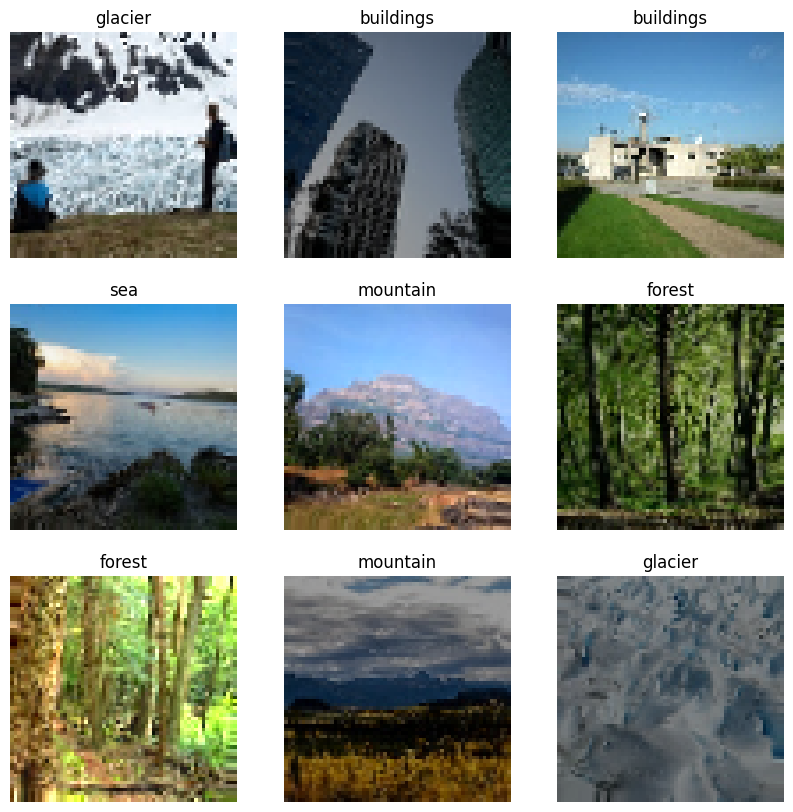

In [8]:
sample_images(train)

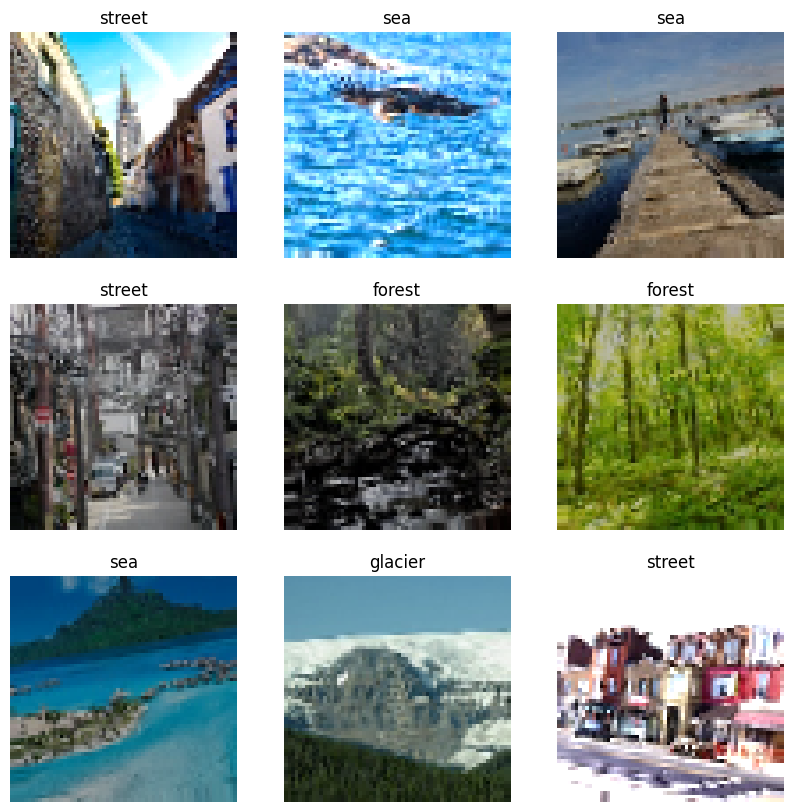

In [9]:
sample_images(validation)

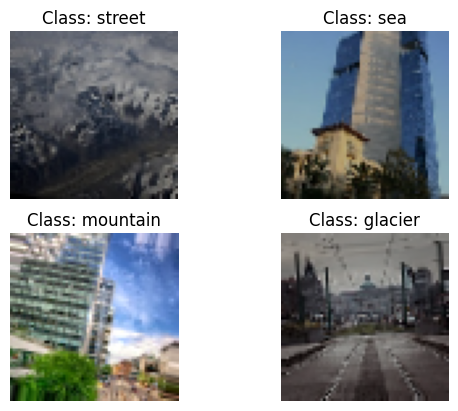

Media: [0.43028325 0.45932138 0.46332082]
Desviación estandar: [0.26821816 0.27231687 0.3067355 ]


In [10]:
for x_batch, y_batch in train:
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(x_batch[i])
        plt.title(f"Class: {CLASES[i]}")
        plt.axis('off')
    plt.show()

    mean = np.mean(x_batch, axis=(0, 1, 2))
    std = np.std(x_batch, axis=(0, 1, 2))

    plt.figure(figsize=(8, 4))
    channels = ['R', 'G', 'B']
    
    plt.bar(channels, mean, color='skyblue', label='Media')
    plt.errorbar(channels, mean, yerr=std, fmt='o', color='red', label='Desviación Estándar', capsize=5)
    plt.ylabel("Valor")
    plt.title("Media y Desviación Estándar por Canal")
    plt.legend()
    plt.show()
    break

In [11]:
contador_imagenes = {}
for subcarpeta, _, _ in os.walk(TRAIN_DIR):
    imagenes = tf.io.gfile.glob(os.path.join(subcarpeta, "*.jpg"))
    contador_imagenes[subcarpeta] = len(imagenes)

clasesplt = []
cantidades = []

for clase, cantidad in contador_imagenes.items():
        partes = clase.split('\\')
        clases = partes[-1].split(".")[0]      
        clasesplt.append(clases)
        cantidades.append(cantidad)

clasesplt.pop(0)
cantidades.pop(0)
plt.figure(figsize=(10, 6))
plt.bar(clasesplt, cantidades, color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Cantidad de Imágenes')
plt.title('Cantidad de Imágenes por Clase')
plt.xticks(rotation=45)
plt.show()

La clase /media/federico/secondary/Repositorios/UCSE/MachineLearning/data_tp2/train tiene 0 imágenes.
La clase /media/federico/secondary/Repositorios/UCSE/MachineLearning/data_tp2/train/buildings tiene 1753 imágenes.
La clase /media/federico/secondary/Repositorios/UCSE/MachineLearning/data_tp2/train/forest tiene 1817 imágenes.
La clase /media/federico/secondary/Repositorios/UCSE/MachineLearning/data_tp2/train/glacier tiene 1924 imágenes.
La clase /media/federico/secondary/Repositorios/UCSE/MachineLearning/data_tp2/train/mountain tiene 2010 imágenes.
La clase /media/federico/secondary/Repositorios/UCSE/MachineLearning/data_tp2/train/sea tiene 1820 imágenes.
La clase /media/federico/secondary/Repositorios/UCSE/MachineLearning/data_tp2/train/street tiene 1906 imágenes.


# Modelado de Redes Neuronales

In [12]:
# el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
input_shape = (SIZE, SIZE, 3)
input_shape

(64, 64, 3)

## MLP

In [13]:
mlp = Sequential([
    Input(input_shape),
    
    Flatten(),

    Dense(500, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CLASES), activation='softmax'),
])

In [14]:
mlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [15]:
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     6,144,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,147,506 (23.45 MB)

 Trainable params: 6,147,506 (23.45 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamos la red, pero por una cuestión teórica, ya suponemos que este tipo de redes no es óptima para problemas de imágenes

Los resultados son un desastre, está underfitteando. En la primer etapa da casi la misma medición de accuracy que en la quinta

## Red Convolucional

Al principio probamos con los parámetros tal cual están en el notebook de ejemplo de la materia, teniendo una accuracy en validation de 0.67 y de 0.68 en train

In [17]:
convolutional = Sequential([
    Input(input_shape),

    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CLASES), activation='softmax'),
])

In [18]:
convolutional.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [19]:
convolutional.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 61, 61, 10)     │           490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 61, 61, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 58, 10)     │         1,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 58, 58, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       196,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,806 (776.59 KB)

 Trainable params: 198,806 (776.59 KB)

 Non-trainable params: 0 (0.00 B)

Agregamos algunas mejoras:
- Más cantidad de filtros, y los vamos aumentando con cada capa
- Reducimos el kernel para que sea más chico y encuentre detalles más finos
- Aumentamos el dropout para compensar el overfitting que podría sumar el aumentar los filtros y reducir el kernel
- Cambiamos el método de pooling de Flatten a GlobalAveragePooling2D (por lo que investigamos anda mejor con imágenes)
- Incrementamos la cantidad de neuronas (puede aportar también al overfitting)
- Usamos relu en lugar de tanh como función de activación en la capa Densa antes de la salida
- Agregamos BatchNormalization entre cada capa

In [20]:
convolutional2 = Sequential([
    Input(shape=input_shape),

    Convolution2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Convolution2D(filters=64, kernel_size=(3, 3), strides=1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Convolution2D(filters=128, kernel_size=(3, 3), strides=1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(CLASES), activation='softmax'),
])

In [21]:
convolutional2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [22]:
convolutional2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,734 (506.77 KB)

 Trainable params: 128,774 (503.02 KB)

 Non-trainable params: 960 (3.75 KB)

### Entrenamiento

In [23]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

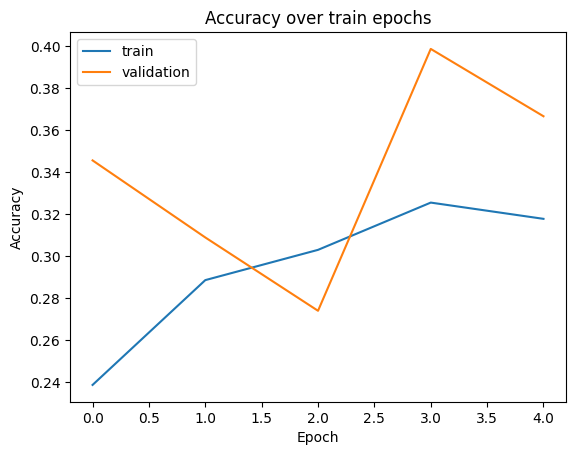

In [24]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()